In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
cities = pd.read_csv("data/cities.csv")
temps = pd.read_csv("data/temperatures.csv")
troops = pd.read_csv("data/troops.csv")

troops_np = troops.to_numpy()
cities_np = cities.to_numpy()
temps = temps.to_numpy()

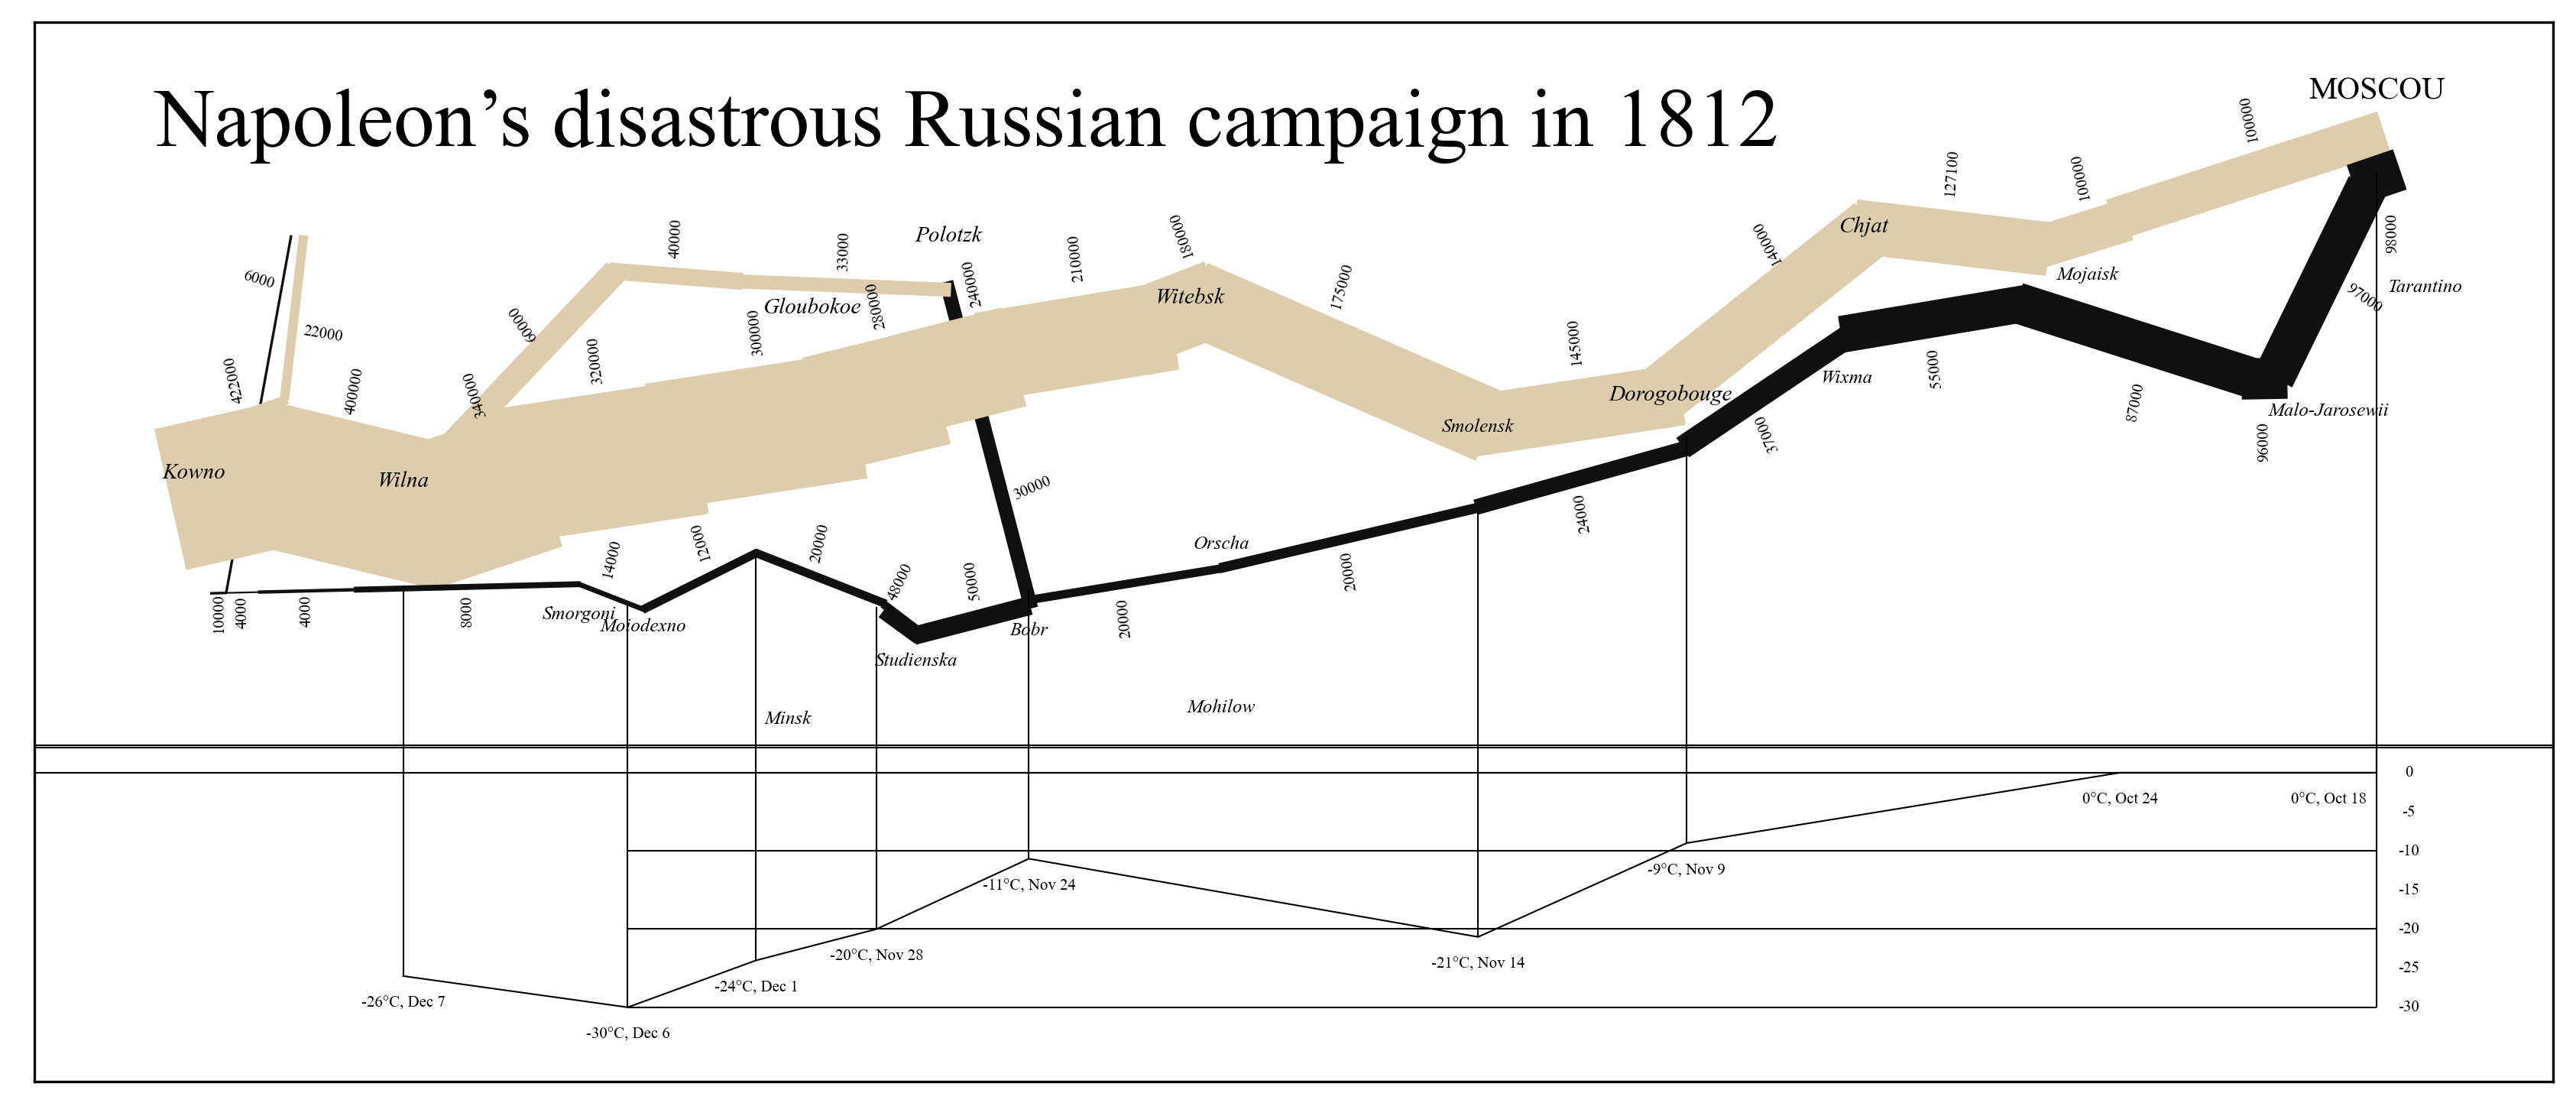

In [3]:
import matplotlib as mpl
from matplotlib.collections import LineCollection

# region global variables for plotting
old_dpi = mpl.rcParams['figure.dpi']
mpl.rcParams['figure.dpi'] = 300
fig, ax = plt.subplots(figsize=(15, 6))

colors = ['#decdac', '#101010']
txt_font = {'fontname':'Times New Roman'}
bbox_prop = dict(facecolor='1', alpha=0.3, edgecolor='none')

# tweak y axis for better visualization
y_cosmetic_offset = np.zeros(len(troops_np))
y_cosmetic_offset[[0, 1, 35, 36, 45, 46]] = -0.25
y_cosmetic_offset[[47, 48,40, 41]] = -0.15
y_cosmetic_offset[38] = -0.25; y_cosmetic_offset[39] = -0.2
y_cosmetic_offset[[37, 2]] = 0.05
# tilt the plot
x_min = np.min(troops_np[:, 0]); x_max = np.max(troops_np[:, 0])
tilt_y = 0.1
tilt_offset = np.interp(troops_np[:, 0].astype(float), [x_min, x_max], [-tilt_y, tilt_y])
y_cosmetic_offset += tilt_offset

troops_wi = np.hstack((troops_np, np.arange(len(troops_np)).reshape(-1, 1)))
troops_wi[:, 1] += y_cosmetic_offset
troops = np.copy(troops_wi)
# endregion

# region plot retreat and advance path
def extend(px, py, w, w_scale = 0.5):
    '''Extend line segment by width w
    '''
    flip = 0
    if px[0] > px[1]:
        flip = 1
        px = np.flip(px)
        py = np.flip(py)

    x = np.array([px[0]-w*w_scale, px[1]+w*w_scale], dtype=np.float64)
    y = np.interp(x, px.astype(np.float64), py.astype(np.float64))
    
    return np.array([x, y])

def plot_troops(tp, ax, color, y_offset=0, x_offset=0, lwidth_norm=7500, capsize_norm=150):
    x = tp[:, 0]+x_offset
    y = tp[:, 1]+y_offset
    #print(x, y)
    lwidths = tp[:, 2].astype(float)/lwidth_norm
    
    seg = []
    for i in range(len(x)-1):
        new_pair = extend(x[i:i+2], y[i:i+2], lwidths[i]/capsize_norm)
        seg.append(new_pair.T)
    seg = np.array(seg)
    
    lc = LineCollection(seg, 
                        linewidths=lwidths, 
                        colors=color,
                        capstyle='butt',
                        joinstyle='bevel',
                        )
    ax.add_collection(lc)
    


retreat_offset = -0.055

for i in [1, 2]:
    temp = troops[troops[:, 4] == i + 1]
    temp_ret = temp[temp[:, 3] == 'retreating']
    temp_ret[1:, 1] += retreat_offset
    
    if i == 1: offset = 0.03
    else: offset = -0.04
    plot_troops(temp_ret, ax, colors[1], y_offset=offset)


for i in range(3):
    temp = troops[troops[:, 4] == i + 1]
    temp_adv = temp[temp[:, 3] == 'advancing']
    if i != 2: plot_troops(temp_adv, ax, colors[0])
    else: plot_troops(temp_adv, ax, colors[0], y_offset=-0.04, x_offset=0.07)
    
temp = troops[troops[:, 4] == 1]
temp_ret = temp[temp[:, 3] == 'retreating']
temp_ret[1:, 1] += retreat_offset
plot_troops(temp_ret, ax, colors[1], y_offset=-0.04)


#endregion

# region plot cities
cities = np.copy(cities_np)
offset_y = np.array([-0.25, 0, -0.15, -0.1, 0.1, -0.05, -0.25, 0.05, -0.25, 0, -0.05, -0.05, 0, 0, -0.2, 0, -0.2, 0.15, 0, -0.15])
offset_y[[2, 3, 5, 6, 8, 10, 11, 14, 18, 19]] += retreat_offset
tilt_offset = np.interp(cities[:, 0].astype(float), [x_min, x_max], [-tilt_y, tilt_y])
offset_y += tilt_offset

offset_x = np.array([0, 0, 0, 0, 0.15, 0.1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, -0.2, 0, 1.3, 0.8])
sizes = np.ones(len(cities))*6; sizes[-3] = 10
sizes[[0, 1, 4, 7, 9, 13, 15]] = 7
cities[-3, 2] = "MOSCOU"

styles = ['italic'] * len(cities)
styles[-3] = "normal"

for i in range(len(cities)):
    ax.text(cities[i, 0]+offset_x[i], 
            cities[i, 1]+offset_y[i], 
            cities[i, 2], 
            color='k', 
            ha='center', va='center', 
            size=sizes[i],
            style=styles[i],
            **txt_font)

#endregion

# region plot number of troops

troops = np.copy(troops_wi)

def mid_point(x, y, y_offset=0, x_offset=0):
    return np.array([np.mean(x)+x_offset, np.mean(y)+y_offset])
def angle(x, y):
    deg = np.arctan2(y[1]-y[0], x[1]-x[0]) * 180 / np.pi
    if deg < 0: deg += 180
    deg += 90; deg %= 180
    if deg > 130: deg -= 180
    return deg


# overlapping data
adv_ol_idx = [35, 36, 45]
ret_ol_idx = [50, 43, 44]
ol_idx = adv_ol_idx + ret_ol_idx
ex_idx = ol_idx + [37, 46, 49, 42]

for i in ol_idx:
    troops[np.logical_and.reduce(
        [np.invert(np.isin(troops[:, 5], ex_idx)), 
        troops[i, 0] == troops[:, 0], 
        troops[i, 3] == troops[:, 3]] )
           , 2] \
            += troops[i, 2]
troops = np.delete(troops, ol_idx, axis=0)


adv_offset = 0.3
ret_offset = -0.15
x_offset = np.zeros(len(troops_np))
x_offset[18] = 0.27; x_offset[17] = 0.1; x_offset[46] = 0.25; x_offset[6] = 0.1; x_offset[42] = 0.27
y_offset = troops_np[:, 2].astype(float)/150000
y_offset = np.sqrt(y_offset)/4
y_offset[troops_np[:, 3]=='retreating'] *= -1
y_offset[troops_np[:, 3]=='retreating'] += 0.03
y_offset[troops_np[:, 3]=='advancing'] += 0.11
y_offset[17] -= retreat_offset
y_offset[26:31] += 0.25; y_offset[49] += 0.6

directions = ['advancing', 'retreating']
for i in range(3): 
    for k in range(2): 
        temp = troops[troops[:, 4] == i + 1]
        temp_1 = temp[temp[:, 3] == directions[k]]
        if k == 1: temp_1 = np.flip(temp_1, axis=0); offset = ret_offset;
        else: offset = adv_offset;
        
        for j in range(len(temp_1)-1):
            x, y = mid_point(temp_1[j:j+2, 0], temp_1[j:j+2, 1], y_offset=-0.1)
            rot = angle(temp_1[j:j+2, 0], temp_1[j:j+2, 1])
            if (rot>-45 and rot<45) and temp_1[j, 5] not in [49,]: use_y_offset = 0
            else: use_y_offset = 1
            ax.text(x+x_offset[temp_1[j, 5]], y+y_offset[temp_1[j, 5]]*use_y_offset+retreat_offset*k,
                    str(temp_1[j, 2]),
                    color='k', ha='center', va='center', 
                    rotation=rot,
                    size=5, **txt_font)
#endregion

# region temperature
base_lat = 53.1
temps_data = np.copy(temps)
temp_scale = 0.3
temp_normed = temps_data[:, 1]
mean = np.mean(temp_normed); std = np.std(temp_normed)
temp_normed = (temp_normed - mean) / std * temp_scale + base_lat

temp_ticks = -np.arange(0, 31, 5)
temp_ticks_loc = (temp_ticks - mean) / std * temp_scale + base_lat
temp_lines = -np.arange(0, 31, 10)
temp_lines_loc = (temp_lines - mean) / std * temp_scale + base_lat

temp_x_offset = np.array([0, 0, 0.1, 0, 0, -0.25, 0.3, 0, 0])
temps_data[:, 0] += temp_x_offset

ax.plot(temps_data[:, 0], temp_normed, color='k', lw=0.5)

for i in range(len(temps_data)):
    if i == 0: temp_offset = -0.3
    else: temp_offset = 0
    ax.text(temps_data[i, 0] + temp_offset, temp_normed[i] - 0.1, 
            #str(temps_data[i, 1])+'°C',
            str(temps_data[i, 1])+'°C, '+ str(temps_data[i, 2])+' '+str(temps_data[i, 3]),
            color='k', ha='center', va='center', 
            size=5, **txt_font)

for i in range(len(temp_ticks_loc)):
    ax.text(temps_data[0, 0] + 0.2, temp_ticks_loc[i],
            temp_ticks[i],
            color='k', ha='center', va='center', 
            size=5, **txt_font)
ax.hlines(temp_lines_loc, temps_data[0, 0], temps_data[-2, 0], color='k', lw=0.5)


def find_nearest(array, value):
    return (np.abs(array - value)).argmin()

temps_data = np.hstack((temps_data, np.arange(len(temps_data)).reshape(-1, 1)))
temps_data = np.delete(temps_data, 1, axis=0)

ret_troops = troops_wi[troops_wi[:, 3]=='retreating', :]
vline_offset = [0, 0, -0.05, 0, -0.05, -0.05, -0.025, -0.025]
for i in range(len(temps_data)):
    idx = find_nearest(ret_troops[:, 0], temps_data[i, 0])
    t_idx = temps_data[i, -1]
    ax.vlines(temps_data[i, 0], temp_normed[t_idx], ret_troops[idx, 1]+retreat_offset+vline_offset[i], color='k', lw=0.5)


#endregion

# region adjust figure
x_min = np.min(troops[:, 0])-1
x_max = np.max(troops[:, 0])+1
y_min = np.min(troops[:, 1])-0.25
y_max = np.max(troops[:, 1])+0.25


ax.set_xlim(x_min, x_max)
ax.set_ylim(y_min-1.5, y_max+0.15)

ax.set_aspect(1.7, adjustable='box')
#plt.axis('off')
ax.set_xticks([])
ax.set_yticks([])

ax.text(x_min+0.75, y_max-0.3, 'Napoleon’s disastrous Russian campaign in 1812', size=26, **txt_font)

# plot auxiliary lines
ax.hlines([base_lat+0.55, base_lat+0.54], x_min, x_max, color='k', lw=0.5)
ax.hlines(temp_lines_loc[0], x_min, temps_data[0, 0], color='k', lw=0.5)
ax.vlines(temps_data[0, 0], temp_lines_loc[-1], temp_normed[0]+0.1, color='k', lw=0.5)

#endregion

mpl.rcParams['figure.dpi'] = old_dpi

1. some global variables are defined for plotting,  
y coords are offsetted by tilt the path and reduce large gaps between paths  
index of troop data is stacked for easier indexing  
2. 2 helper functions are created. 1st one is for extending the line segment to simulate a adjustable linecap; 2nd plot the line segments of the paths with variable line width, LineCollection is used to avoid multiple plotting.  
the plots of the paths are reordered (lowest z order plotted first) to achieve the desired effect, retreating path are moved down to avoid overlapping with advancing path
3. cities are plotted using adjusted coordinates to avoid overlapping with paths
4. number of troops are plotted using the midpoint of the path segments and rotated to match the path orientation
5. temperatures are normalized then plotted below the paths, top of the vertical lines are chosen from the nearest path segment then manually adjusted for better visual effect, temperatures and dates are plotted below the temperature line
6. other auxiliary elements are then plotted, e.g. legend, temperature scale, etc.
    
